<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Collect-Data" data-toc-modified-id="Collect-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Collect Data</a></span></li><li><span><a href="#Visualizing-the-Data-with-WordClouds" data-toc-modified-id="Visualizing-the-Data-with-WordClouds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing the Data with WordClouds</a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sentiment Analysis</a></span><ul class="toc-item"><li><span><a href="#nltk" data-toc-modified-id="nltk-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>nltk</a></span></li></ul></li><li><span><a href="#Calculate-Polarity-Scores" data-toc-modified-id="Calculate-Polarity-Scores-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculate Polarity Scores</a></span><ul class="toc-item"><li><span><a href="#Sentiment:-reliable-vs-unreliable" data-toc-modified-id="Sentiment:-reliable-vs-unreliable-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Sentiment: reliable vs unreliable</a></span></li></ul></li><li><span><a href="#Frequency-Distribution" data-toc-modified-id="Frequency-Distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Frequency Distribution</a></span></li></ul></div>

## Libraries

In [36]:
from IPython.display import Image
from IPython.display import IFrame
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format ='retina'

import os
import re
import json
import string

from collections import Counter
from tabulate import tabulate
from html.parser import HTMLParser
from tqdm import tqdm
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.style import set_palette
set_palette('muted')

from wordcloud import WordCloud, STOPWORDS

import plotly 
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import cufflinks as cf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
config_file = os.path.join(str(Path.home()), '.auth/plotly.json')
with open(config_file) as f:
    tokens = json.load(f)
    
plotly.tools.set_credentials_file(username=tokens['username'], api_key=tokens['token'])
plotly.offline.init_notebook_mode(connected=True)

In [3]:
print(plotly.__version__)

3.5.0


## Collect Data

Let us have a closer look at the data we got via webhose.io. We shall read in the text files and put everything into a dataframe with its proper category label.

In [7]:
filenames = [name for name in os.listdir('url_data/')]
print(filenames)

['satire.txt', 'clickbait.txt', 'bias.txt', 'conspiracy.txt', 'reliable.txt', 'combined_unreliable.txt', 'political.txt', 'fake.txt', 'junksci.txt', 'unreliable.txt']


In [5]:
lines = []
catgy = []

with tqdm() as progress:
    for fname in filenames:
        for line in open('url_data/' + fname):
            lines.append(line.rstrip('\n').rstrip("\'").lstrip("b\'"))
            catgy.append(fname.split('.')[0])

        progress.update()

10it [00:00, 28.17it/s]


In [6]:
df = pd.DataFrame({'news_content': lines, 'category': catgy})
df.to_csv('data/combined_news_content.csv', index=False)

In [8]:
df = pd.read_csv('data/combined_news_content.csv')
categories = df.category.value_counts()

labels = categories.index.tolist()
content_values = categories.values.tolist()

In [9]:
trace = go.Pie(labels=labels, values=content_values, hoverinfo='label+percent', textinfo='value', 
               title='Categories by Amount of Content')
py.iplot([trace], filename='categories_by_amount_of_content')

In [10]:
source_df = pd.read_csv('data/url_sources.csv')
categories = source_df.category.value_counts()

labels = categories.index.tolist()
url_values = categories.values.tolist()

In [11]:
trace = go.Pie(labels=labels, values=url_values, hoverinfo='label+percent', textinfo='value', 
               title="Categories by URL's")
py.iplot([trace], filename='categories_by_url')

We have nearly double the number of url's categorized as fake vs reliable, but we were able to scrap far more data from reliable sources compare to any other.

## Visualizing the Data with WordClouds

By looking at a wordcloud picture we can get some rough sense of which words are more weighted by a given category. But not necessarily to the point that we could create meaningful conclusions from it.

In [12]:
filename = 'url_data/bias.txt'

lines = [line.rstrip('\n').rstrip("\'").lstrip("b\'") for line in open(filename)]
lines[0]

'She was merely following her dreams. That is the meaning of life now.'

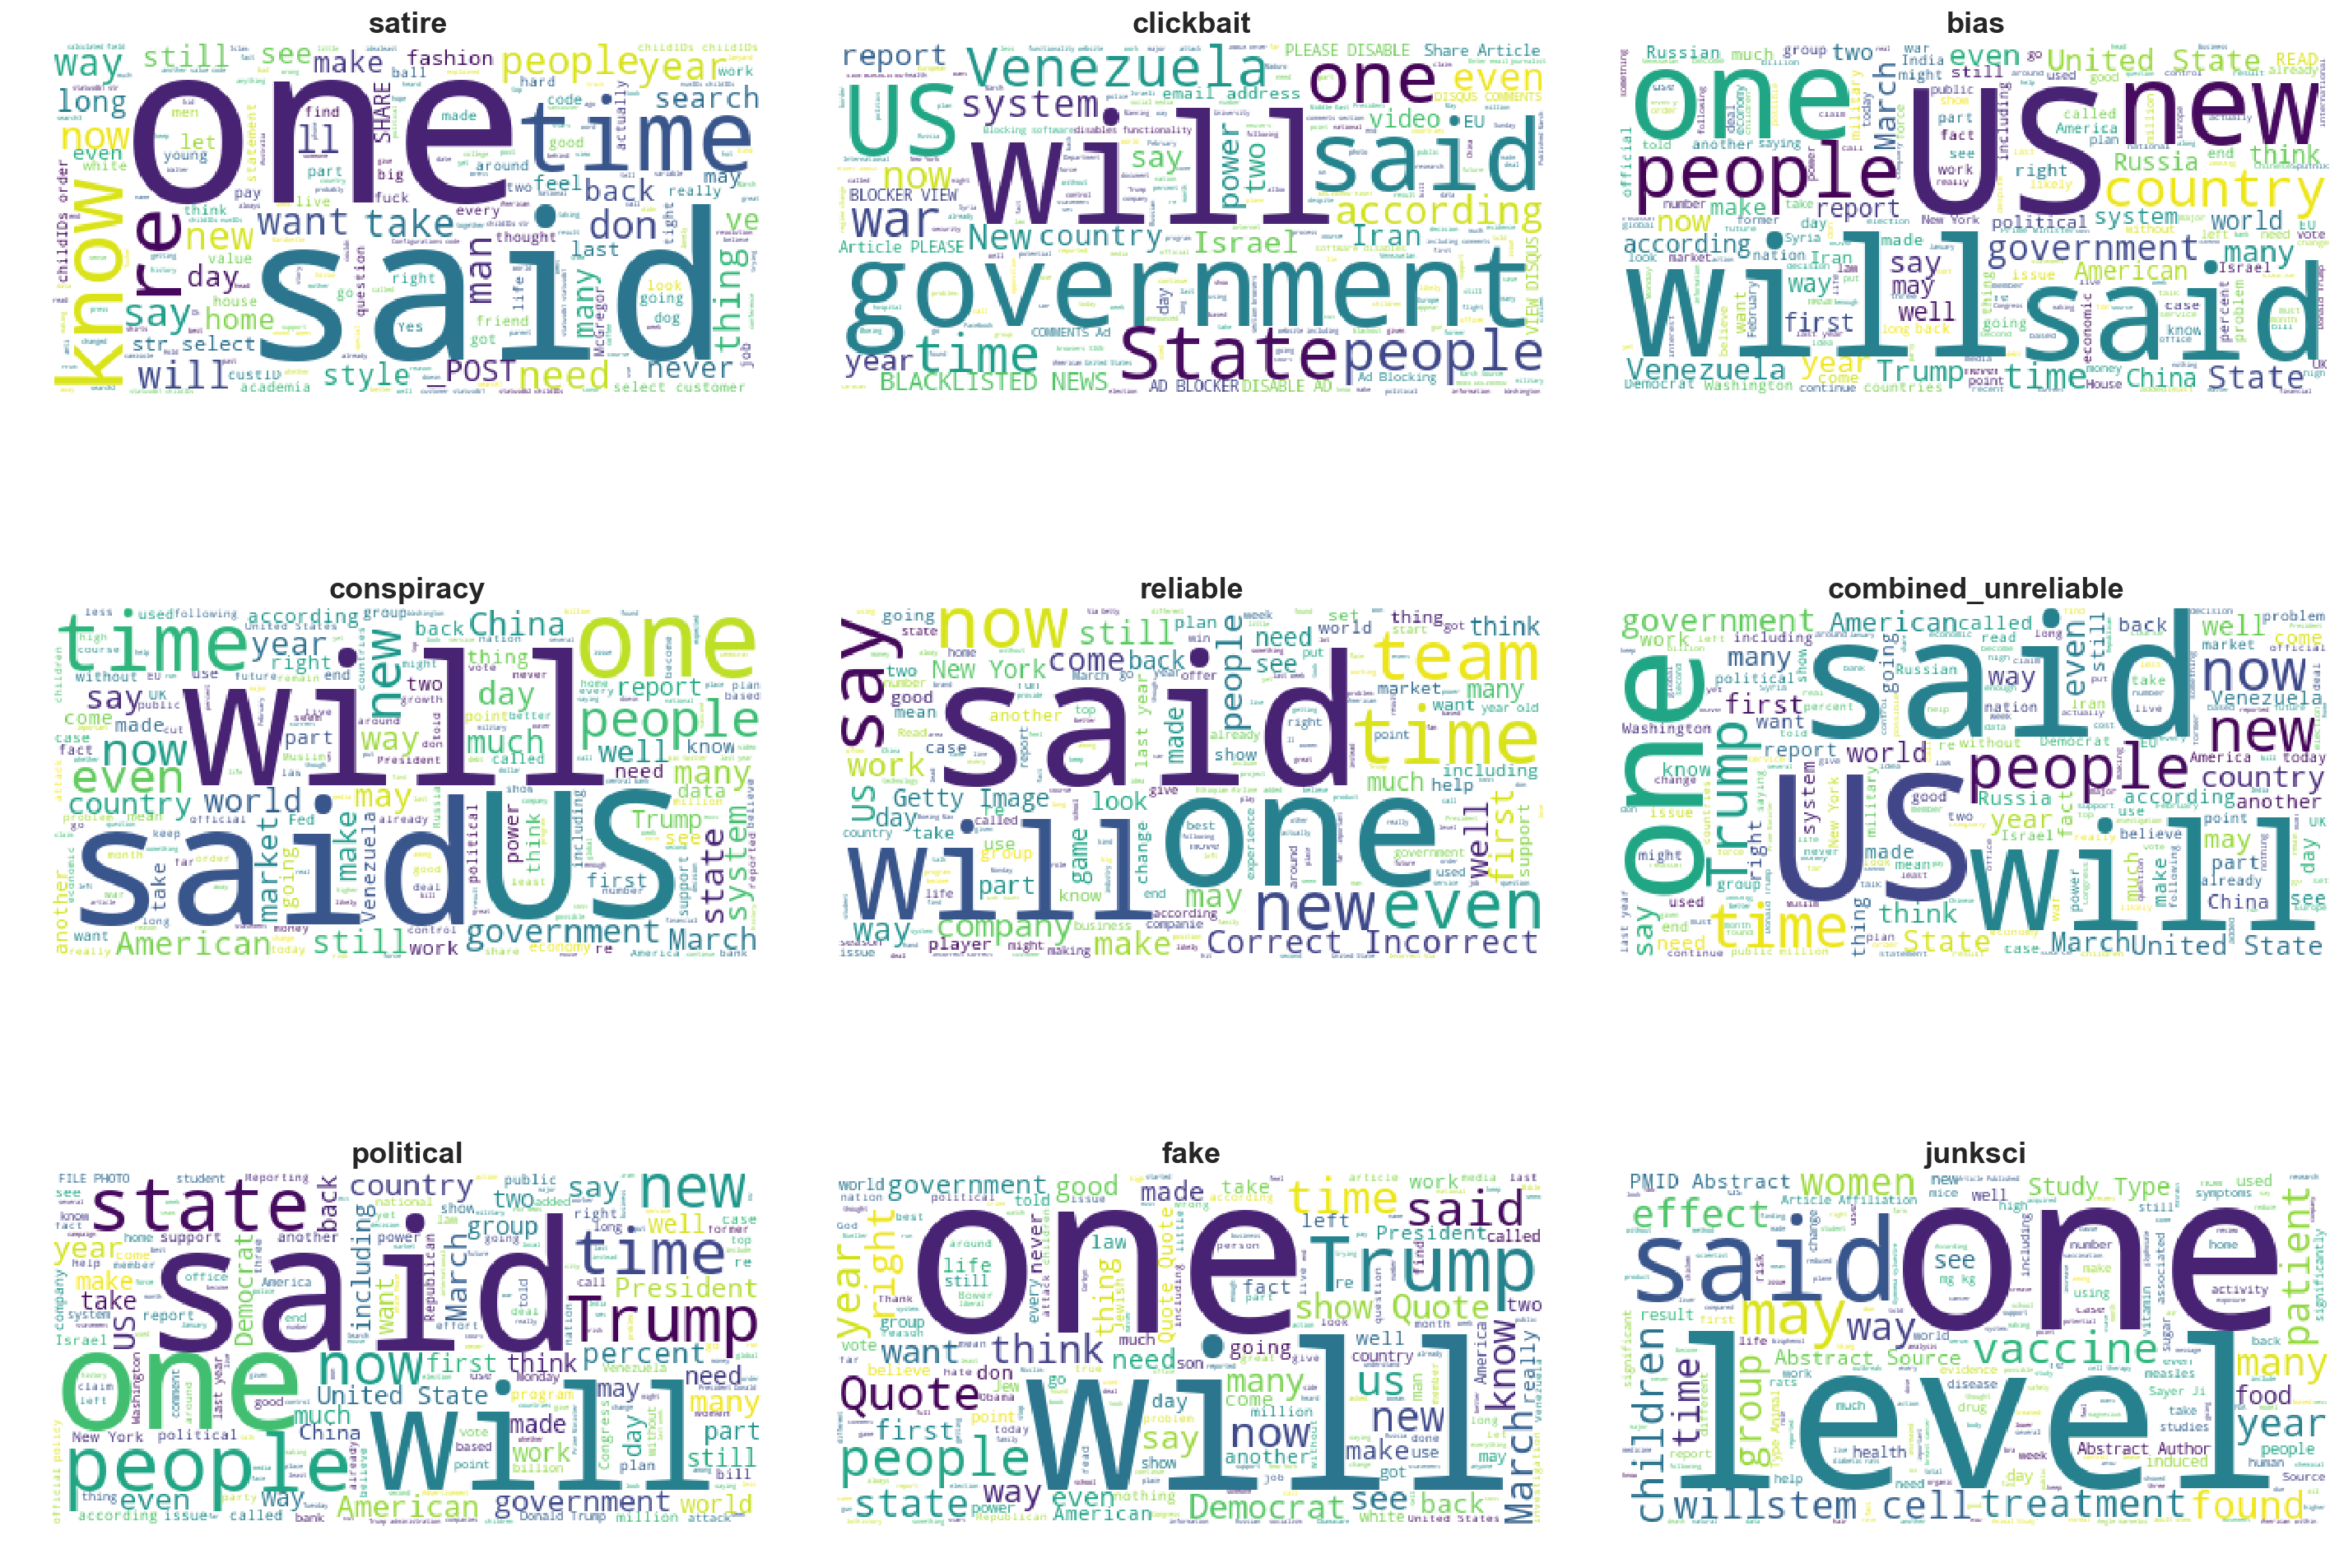

In [13]:
cat_list = df.category.unique().tolist()

ncol = 3
nrow = 3
fig = plt.figure(figsize=(20, 15))
ax = []

for i in range(ncol * nrow):
    news_content = df[df.category==cat_list[i]].news_content.tolist()
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=None, 
        random_state=1 
    ).generate(str(news_content))
    
    ax.append( fig.add_subplot(nrow, ncol, i+1) )
    ax[-1].set_title(cat_list[i], fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.imshow(wordcloud)

plt.tight_layout()
plt.show();

## Sentiment Analysis

### nltk

For our sentiment analysis we will use the vader package from nltk (Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.).

Give a sentiment intensity score to sentences as four values, negative, neutral, positive and compound. Where the compound score value is normalized between -1 and 1 based on the sum of all lexicon ratings in the sentence.

In [14]:
# Instantiate SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

def text_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    print("{}\n\n{}".format(text, str(sentiment)))

In [15]:
text_sentiment_score(df[df['category'] == 'political']['news_content'].iloc[0])

STATEMENT: CAP’s Tom Jawetz Applauds Introduction of H.R. 6, Calls on Congress to Pass Long-Overdue Protections for Dreamers, TPS and DED Beneficiaries Date: March 12, 2019 Contact: Rafael Medina Email: ‮g​r​o​.​s​s​e​r​g​o​r​p​n​a​c​i​r​e​m​a​&commat;​a​n​i​d​e​m​j​r‭ Washington, D.C. — Today, Reps. Lucille Roybal-Allard (D-CA), Nydia M. Velázquez (D-NY), and Yvette D. Clarke (D-NY) introduced H.R. 6, the Dream and Promise Act of 2019—an important bill that provides permanent protections for Dreamers, Temporary Protected Status (TPS) holders, and Deferred Enforced Departure (DED) beneficiaries. Tom Jawetz , vice president of Immigration Policy at the Center for American Progress, issued the following statement: While the Trump administration continues to spew anti-immigrant rhetoric— requesting , yet again, billions of dollars for the president’s vanity project of a border wall just weeks after Congress rejected his last request—House Democrats are making good on their promise to figh

In [16]:
text_sentiment_score(df[df['category'] == 'fake']['news_content'].iloc[0])

18 hours ago Shutterstock Atletico Madrid head to Northern Italy to take on Serie A champions Juventus in the second leg of their epic Champions League matchup. Despite being favored heading into the tie, Juventus find themselves with a substantial hole to climb out of as they conceded two goals to Atletico’s two central defenders at the Wanda Metropolitano Stadium in Madrid back on February 20. If Atletico can find a way to score a single goal at the Allianz, Juventus will need to score four goals against the notoriously stingy Spanish side to advance, as Atleti would hold the away goals advantage. Today’s second leg tie features two of the world’s biggest clubs that are full of some of the world’s best players, so make sure you find out how to live stream the action on your desktop, laptop, or mobile device here. Can’t watch today’s second leg matchup from the comfort of your couch? Find out how to live stream Atletico Madrid take on Juventus in today’s Champions League matchup below

Even so we choose the first text in our dataset the difference between `fake` news and `political` is not particularly great.

## Calculate Polarity Scores

In [17]:
def sentiment_analyze(df):
    """
    Add the sentiment features to the dataframe and 
    define whether or not something is negative or positive
    
    :param df: dataset
    :return: dataset
    """
    
    sentiments = []
    with tqdm() as progress:
        for i in range(df.shape[0]):
            line = df['news_content'].iloc[i]
            sentiment = sia.polarity_scores(line)
            sentiments.append([sentiment['neg'], sentiment['pos'], 
                               sentiment['neu'], sentiment['compound']])
        
            progress.update()
        
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    df['Negative'] = df['compound'] < -0.1
    df['Positive'] = df['compound'] > 0.1

    return df 

In [18]:
df_hist = sentiment_analyze(df)

24098it [03:06, 129.41it/s]


In [19]:
df_hist.to_csv('data/sentiment_analyze.csv', index=False)
df_hist.head()

,news_content,category,neg,pos,neu,compound,Negative,Positive
0,"MANILA, Philippines ( The Adobo Chronicles, Ma...",satire,0.058,0.099,0.842,0.6808,False,True
1,"What boots a tree we cannot climb, Or cut, and...",satire,0.136,0.111,0.753,-0.8233,True,False
2,"Offers no great, grand accounting for the morr...",satire,0.157,0.213,0.629,0.9715,False,True
3,Home › The Rest › Video News › End of the Blue...,satire,0.095,0.159,0.746,0.8054,False,True
4,"It’s time to get some more hard-hitting, punch...",satire,0.115,0.150,0.735,0.9725,False,True


In [20]:
hist_data = df_hist.drop(['news_content', 'category', 'Negative', 'Positive'], axis=1)
hist_data.iplot(kind='histogram', subplots=True, shape=(4, 1), filename='sentiment_analyze_histogram')

In [21]:
percentiles = hist_data['compound'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
percentiles

count    24098.000000
mean         0.203178
std          0.763001
min         -1.000000
10%         -0.963790
20%         -0.774180
30%         -0.372100
40%          0.000000
50%          0.440400
60%          0.757120
70%          0.923090
80%          0.980500
90%          0.995500
max          1.000000
Name: compound, dtype: float64

From the distribution above we can see that the content we have gathered is very much devided between negative, positive and neutral.

In [22]:
# Group data together
hdata = [hist_data['neg'], hist_data['pos']]
labels = ['negative', 'positive']

# Create distplot with custom bin_size
fig = ff.create_distplot(hdata, labels, bin_size=.01, )
fig['layout'].update(title='Positive Negative Distribution')

py.iplot(fig, filename='posneg_distplot')

Layout({
    'barmode': 'overlay',
    'hovermode': 'closest',
    'legend': {'traceorder': 'reversed'},
    'title': {'text': 'Positive Negative Distribution'},
    'xaxis': {'anchor': 'y2', 'domain': [0.0, 1.0], 'zeroline': False},
    'yaxis': {'anchor': 'free', 'domain': [0.35, 1], 'position': 0.0},
    'yaxis2': {'anchor': 'x', 'domain': [0, 0.25], 'dtick': 1, 'showticklabels': False}
})

The draw time for this plot will be slow for clients without much RAM.


If we compare negative and positive content directly we see that they are pretty close together in their distribution.

In [23]:
# get the top 30% from the reliable news (positive)
pos_df = df.loc[df['compound'] >= 0.7]
pos_news = pos_df['news_content'].to_list()

# get the bottom 30% from the reliable news (negative)
neg_df = df.loc[df['compound'] <= 0.3]
neg_news = neg_df['news_content'].to_list()

In [24]:
# Get the content length
pos_df['length'] = pos_df['news_content'].apply(len)
neg_df['length'] = neg_df['news_content'].apply(len)

In [25]:
# Group data together
hdata = [pos_df['length'], neg_df['length']]
labels = ['positive', 'negative']

# Create distplot with custom bin_size
fig = ff.create_distplot(hdata, labels, bin_size=.1)
fig['layout'].update(title='Positive Negative by Text Length')

py.iplot(fig, filename='NegPos_by_TextLength')

Layout({
    'barmode': 'overlay',
    'hovermode': 'closest',
    'legend': {'traceorder': 'reversed'},
    'title': {'text': 'Positive Negative by Text Length'},
    'xaxis': {'anchor': 'y2', 'domain': [0.0, 1.0], 'zeroline': False},
    'yaxis': {'anchor': 'free', 'domain': [0.35, 1], 'position': 0.0},
    'yaxis2': {'anchor': 'x', 'domain': [0, 0.25], 'dtick': 1, 'showticklabels': False}
})

Comparing positive and negative content by their length (number of written words), we see that negative content has overwhelmingly less written words compared to positive content.

In [26]:
neg = abs(percentiles['30%'])
neu = abs(percentiles['70%'] - percentiles['30%'])
pos = abs(percentiles['max'] - percentiles['70%'])

labels = ['Negative Content', 'Neutral Content', 'Positive Content']
values = [neg, neu, pos]

In [27]:
trace = go.Pie(labels=labels, values=values, hoverinfo='label+percent', textinfo='value', 
               title='Positive-Neutral-Negative Content Distribution')
py.iplot([trace], filename='ContentDistChart')

Nearly 75% of the content is considered neutral. But with over 20% negative content vs just 4.45% positive content, we have a huge discrepancy in the content. Discrepancy is probably not the correct word to use here. It seems to reflect the feeling that the news are tent to be more negative. 

### Sentiment: reliable vs unreliable

Let us compare reliable and unreliable content directly.

In [28]:
reliable_df   = df_hist[df_hist['category'] == 'reliable']
unreliable_df = df_hist[(df_hist.category != 'reliable') & (df_hist.category != 'political') &
                        (df_hist.category != 'junksci') & (df_hist.category != 'clickbait') &
                        (df_hist.category != 'satire')]

In [29]:
print('Number of reliable articles: {}'.format(reliable_df.shape[0]))
print('Number of unreliable articles: {}'.format(unreliable_df.shape[0]))

Number of reliable articles: 14856
Number of unreliable articles: 7084


To make sure that we have a "balanced" view of the data we will create same size datasets.

In [30]:
# Randomly sample elements from your dataframe
reliable_df = reliable_df.sample(n=7000)
unreliable_df = unreliable_df.sample(n=7000)

In [31]:
v = reliable_df['compound'].values
v = np.around(v, decimals=2)
v = sorted(v.tolist())

c = Counter(v)
ry = np.array([(float(i)/sum(c.values()))*100 for i in c.values()])
rx = np.array(list(c.keys()))

In [32]:
v = unreliable_df['compound'].values
v = np.around(v, decimals=2)
v = sorted(v.tolist())

c = Counter(v)
uy = np.array([(float(i)/sum(c.values()))*100 for i in c.values()])
ux = np.array(list(c.keys()))

In [33]:
trace0 = go.Scatter(
    x = rx,
    y = ry,
    name = 'reliable'
)
trace1 = go.Scatter(
    x = ux,
    y = uy,
    name = 'unreliable'
)

data = [trace0, trace1]

# Edit the layout
layout = dict(title = 'Sentiment: reliabel vs unreliable',
              xaxis = dict(title = 'Compound'),
              yaxis = dict(title = 'Percent Articles'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CompoundSentiment')

As we saw before, we have extremes. It's either or kind of thing. But one observation we can make is that we have more reliable content on the positive side. 

In [34]:
trace1 = go.Bar(
    x=['negative', 'neutral', 'positive', 'compound'],
    y=[reliable_df['neg'].mean(), 
       reliable_df['neu'].mean(),
       reliable_df['pos'].mean(),
       reliable_df['compound'].mean()],
    name='reliable'
)
trace2 = go.Bar(
    x=['negative', 'neutral', 'positive', 'compound'],
    y=[unreliable_df['neg'].mean(), 
       unreliable_df['neu'].mean(),
       unreliable_df['pos'].mean(),
       unreliable_df['compound'].mean()],
    name='unreliable'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Mean Sentiment: reliabel vs unreliable',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='MeanSentiment')

Compounded we see far more reliable content than unreliable.

## Frequency Distribution

What are the 20 most used words after we deleted all stop words in either content?

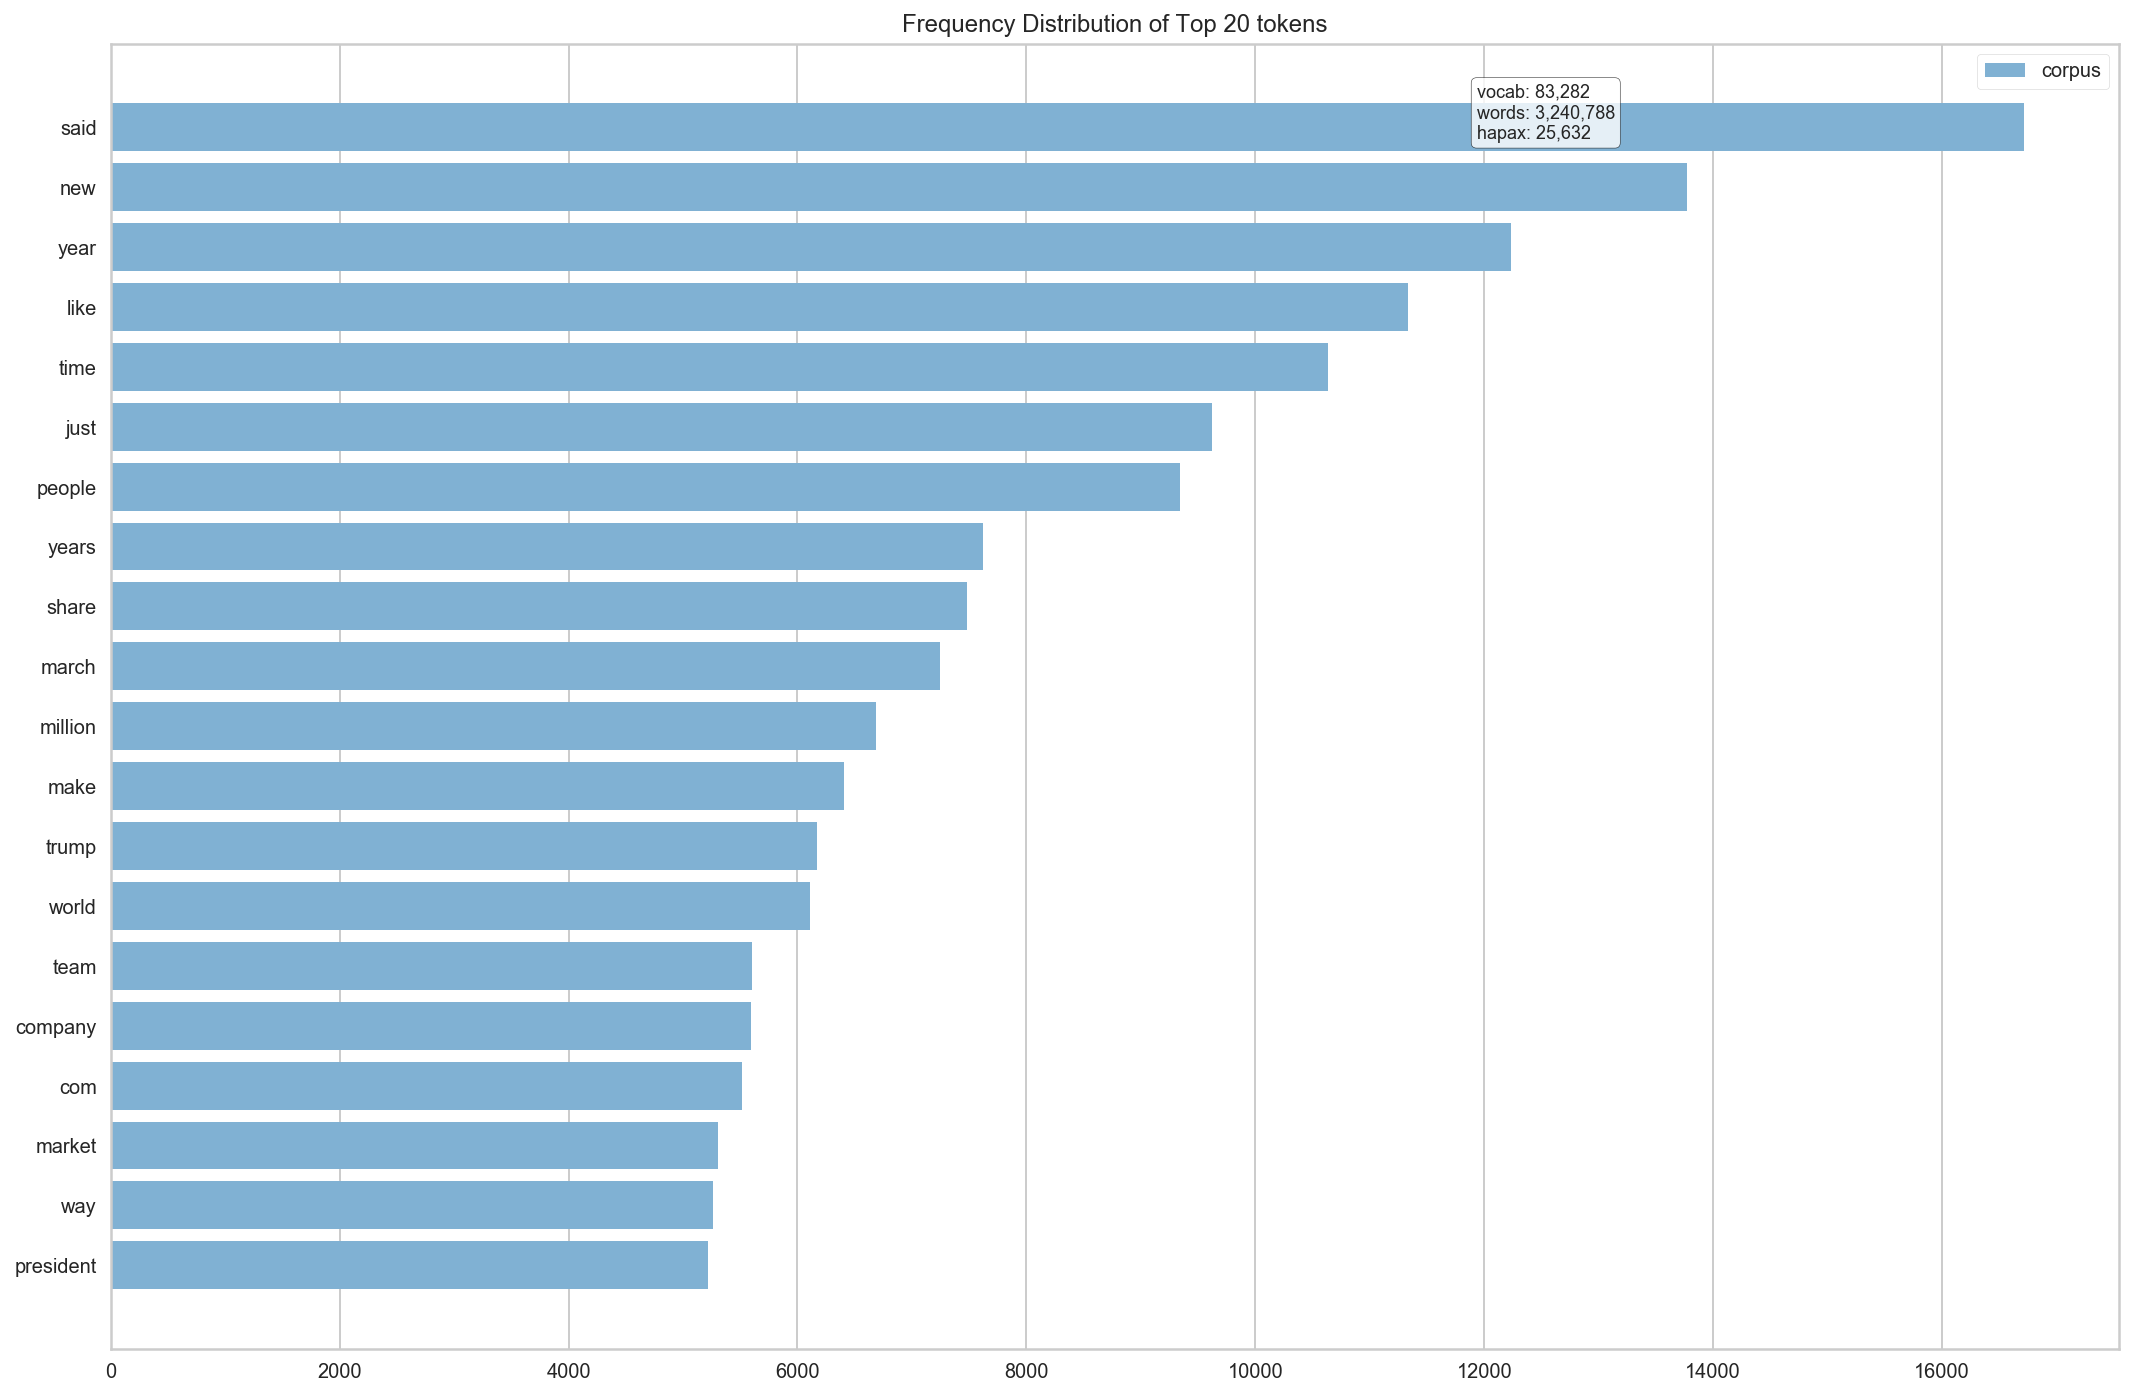

In [37]:
# Instantiate CountVectorizer object and fit positive news and get their features
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b')
docs = tf_vectorizer.fit_transform(pos_news)
features = tf_vectorizer.get_feature_names()

plt.figure(figsize=(18, 12))
# plt.title('20 most frequent words used in POSITIVE news\n', fontweight='bold')

# Instantiate and fit FreqDistVisualizer, plot the top 20 most frequent words
visualizer = FreqDistVisualizer(features=features, n=20, color='blue')
visualizer.fit(docs)
visualizer.poof();

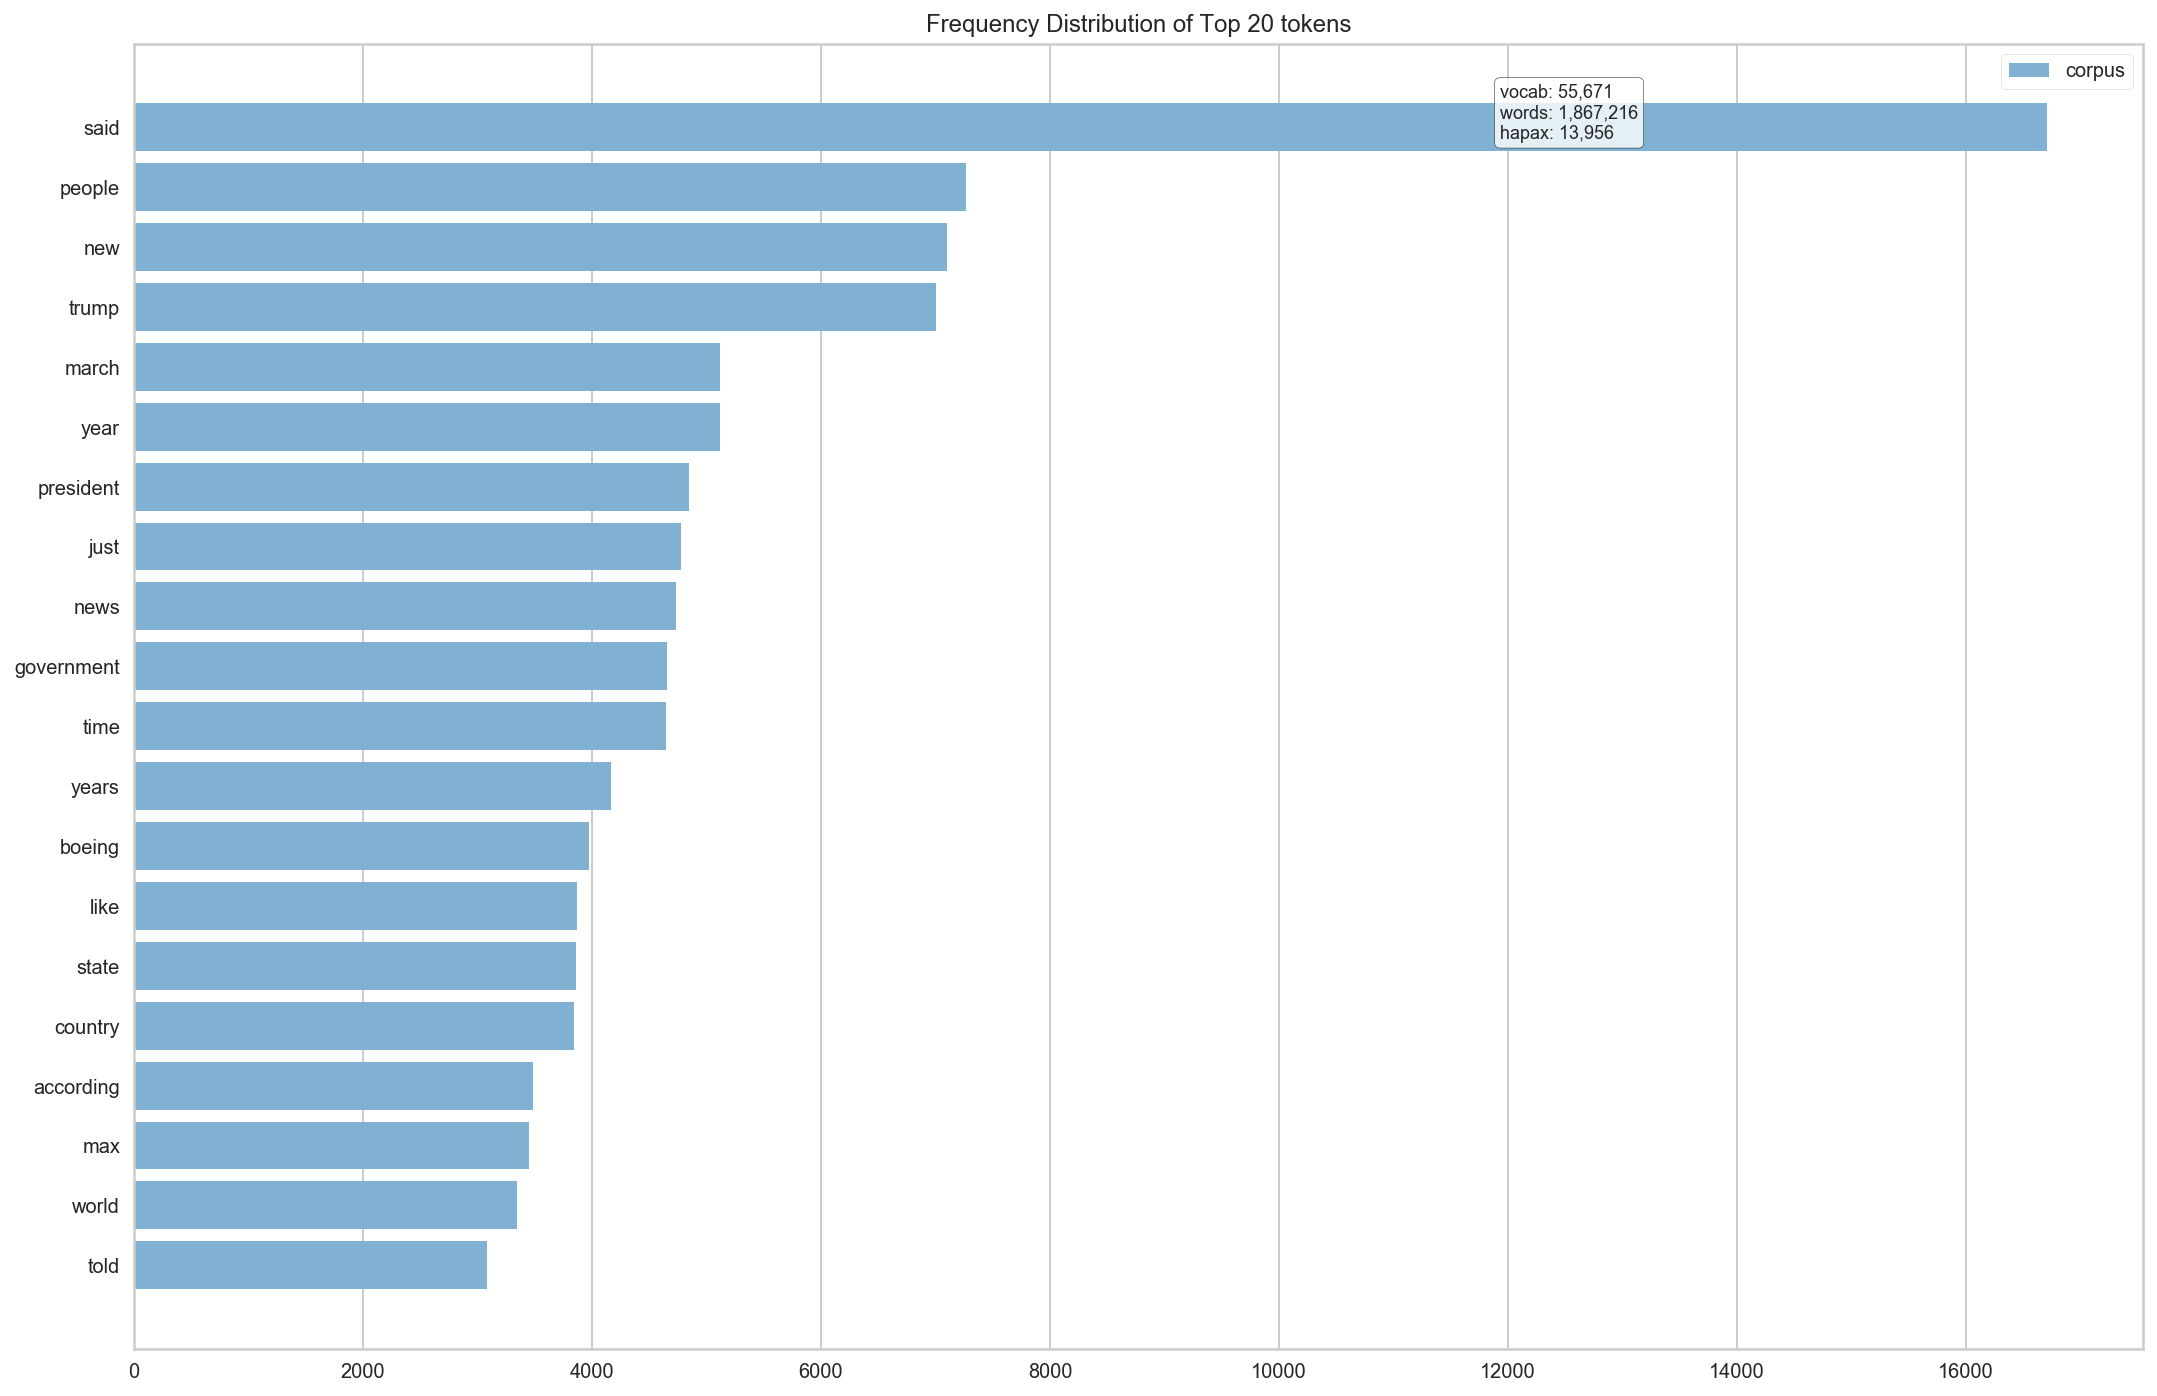

In [39]:
# Instantiate CountVectorizer object and fit negative news and get their features
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b')
docs = tf_vectorizer.fit_transform(neg_news)
features = tf_vectorizer.get_feature_names()

plt.figure(figsize=(18, 12))
# plt.title('20 most frequent words used in NEGATIVE news\n', fontweight='bold')

# Instantiate and fit FreqDistVisualizer, plot the top 20 most frequent words
visualizer = FreqDistVisualizer(features=features, n=20, color="red")
visualizer.fit(docs)
visualizer.poof();

Hmmm, so `said` is **the** word!? But other than that, there are a few similar top ranking words like `people`, `new` and `year`.